# Image Classification - Pap smear images for Cervical Cancer screening
**A simple implementation of a image classifier using Keras**

Data source: SipakMed https://www.kaggle.com/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import shutil

#Tensorflow
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomContrast, RandomTranslation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

Note: when replicating this code, it's possible to have some versioning issues with the imports. The reason behind is that I want to use the GPU/CUDA and TensorFlow 2.10 was the last TensorFlow release that supported GPU on native-Windows.
For more information check: https://www.tensorflow.org/install/pip#windows-native

In [2]:
# Checing if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 1 - Extracting images

For simplicty I already extracted the data from Kaggle to a local archive.zip file.

You can do the same by following this guide: https://www.geeksforgeeks.org/how-to-download-kaggle-datasets-into-jupyter-notebook/

In [3]:
# Let's extract our images in archive.zip
def extract_cropped_images(zip_path, extraction_path):
    # Open the zip file
    with zipfile.ZipFile(zip_path, 'r') as archive:
        # Iterate through each file
        for file_info in archive.infolist():
            # Check if the file is a .bmp file within a CROPPED subfolder
            if file_info.filename.endswith('.bmp') and 'CROPPED' in file_info.filename:
                # Split the path to get the necessary components
                parts = file_info.filename.split('/')
                # Extract the first subfolder name as the label
                label = parts[1]
                # Get the image filename
                image_filename = parts[-1]
                # Destination path
                destination_dir = os.path.join(extraction_path, label)
                destination_path = os.path.join(destination_dir, image_filename)
                # Create the directory (if it doesn't exist)
                os.makedirs(destination_dir, exist_ok=True)
                # Extract the images
                with archive.open(file_info) as source_file:
                    with open(destination_path, 'wb') as dest_file:
                        shutil.copyfileobj(source_file, dest_file)
    print(f"Images extracted!")

TLDR: we just want to grab the *images.bmp* from the **CROPPED** folder inside the *archive.zip* file. And we want to keep these images inside their respective subfolders - these subfolders represent the target labels.

In [4]:
zip_path = '../archive.zip'
extraction_path = '../cropped_images'

In [5]:
extract_cropped_images(zip_path, extraction_path)

Images extracted!


In [7]:
# Checking the number of images of each label
for subfolder in os.listdir(extraction_path):
        subfolder_path = os.path.join(extraction_path, subfolder)
        if os.path.isdir(subfolder_path):
            # Count the number of .bmp files in the subfolder
            num_images = len([name for name in os.listdir(subfolder_path) if name.endswith('.bmp')])
            print(f"{num_images} images in '{subfolder}'.")

813 images in 'Dyskeratotic'.
825 images in 'Koilocytotic'.
793 images in 'Metaplastic'.
787 images in 'Parabasal'.
831 images in 'Superficial-Intermediate'.


# 2 - Training, Validation and Test datasets

In [3]:
# Defining image size and batch size
img_width, img_height = 256, 256
batch_size = 64

In [4]:
# Training and "Validation" datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../cropped_images",
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    seed=183
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../cropped_images",
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=183
)

Found 4049 files belonging to 5 classes.
Using 3240 files for training.
Found 4049 files belonging to 5 classes.
Using 809 files for validation.


In [5]:
# Training and "Validation" datasets batches
print(f"Training dataset: {len(train_ds)} batches")
print(f"Validation dataset: {len(val_ds)} batches")

Training dataset: 51 batches
Validation dataset: 13 batches


In [6]:
# Splitting Validation and Test datasets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

In [7]:
# Training, Validation and Test datasets ~ 80/10/10
print(f"Training dataset: {len(train_ds)} batches")
print(f"Validation dataset: {len(val_ds)} batches")
print(f"Testing dataset: {len(test_ds)} batches")

Training dataset: 51 batches
Validation dataset: 7 batches
Testing dataset: 6 batches


In [8]:
# Our 5 classes (target labels)
class_names = train_ds.class_names
class_names

['Dyskeratotic',
 'Koilocytotic',
 'Metaplastic',
 'Parabasal',
 'Superficial-Intermediate']

In [9]:
# Example of a batch
for img, label in train_ds:
    print(img.shape, label)
    break

(64, 256, 256, 3) tf.Tensor(
[2 2 2 0 0 2 1 2 0 1 1 4 3 0 3 3 0 0 3 4 4 2 1 4 4 2 1 2 0 2 0 0 0 4 2 2 4
 0 1 2 1 1 4 2 4 3 3 3 2 0 2 0 0 2 3 3 2 0 1 2 3 0 4 0], shape=(64,), dtype=int32)


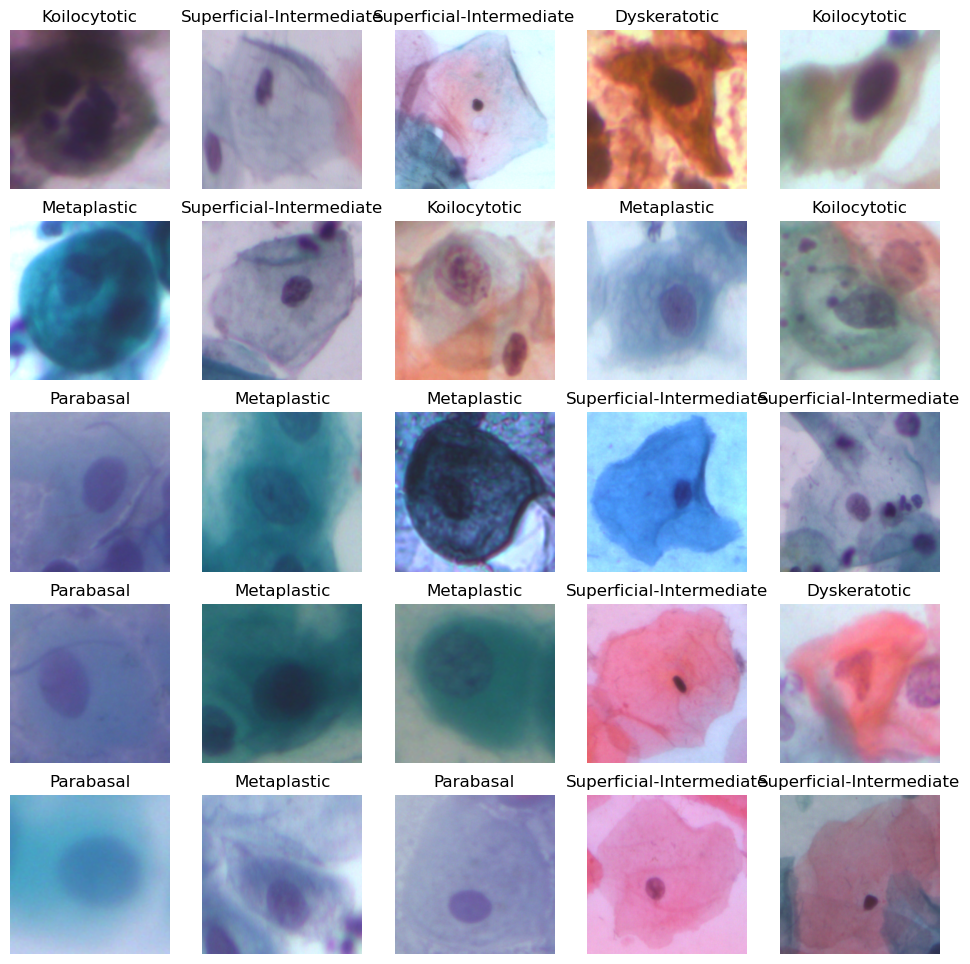

In [10]:
# Visualizing some training images
plt.figure(figsize=(12,12))
for img, label in train_ds:
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')
    break

In [11]:
train_ds = train_ds.cache().shuffle(len(train_ds)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(len(train_ds)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# 3 - Preprocessing

### 3.1 - Resize and Rescale

This is imporant if we want the model to accept different sized images.

In [12]:
# Resize the inpput image to 256x256
# Rescale by 1/255
resize_and_rescale = Sequential([
  Resizing(img_height, img_width),
  Rescaling(1./255),
])

### 3.2 - Data Augmentation on the training dataset

In [13]:
# Data Augmentation on the training dataset
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
  RandomContrast(0.2),
  RandomTranslation(0.1, 0.2),
])

In [14]:
# Applying the data augmentation to the training dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### 3.3 - Testing and visualizing our preprocessed images

In [15]:
# Testing the data augmentation
import random

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image)
    image = tf.expand_dims(image, 0)
    return image

def display_random_images(directory, num_images):
    # Load random images from the directory
    all_images = os.listdir(directory)
    selected_images = random.sample(all_images, num_images)
    selected_image_paths = [os.path.join(directory, image) for image in selected_images]
    
    # Process and visualize each image
    for idx, image_path in enumerate(selected_image_paths):
        image = load_and_preprocess_image(image_path)
        resized_and_rescaled_image = resize_and_rescale(image)
        augmented_image = data_augmentation(resized_and_rescaled_image)
        
        print("Original image shape:", image.shape)
        print("Resized and rescaled image shape:", resized_and_rescaled_image.shape)
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.title(f"Original Image {idx+1}")
        plt.imshow(tf.squeeze(image).numpy())
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title(f"Resized and Rescaled Image {idx+1}")
        plt.imshow(tf.squeeze(resized_and_rescaled_image).numpy())
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title(f"Augmented Image {idx+1}")
        plt.imshow(tf.squeeze(augmented_image).numpy())
        plt.axis('off')
        
        plt.show()

Original image shape: (1, 114, 94, 3)
Resized and rescaled image shape: (1, 256, 256, 3)


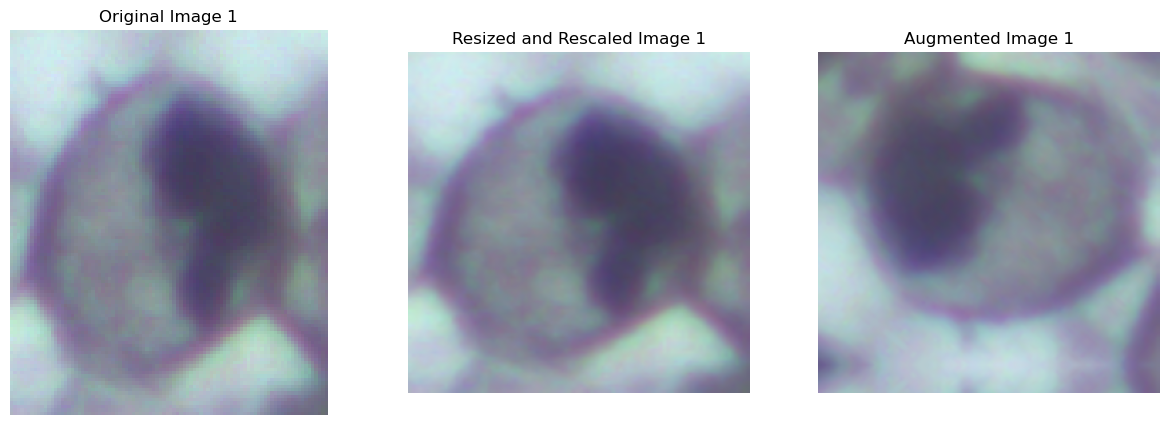

Original image shape: (1, 112, 148, 3)
Resized and rescaled image shape: (1, 256, 256, 3)


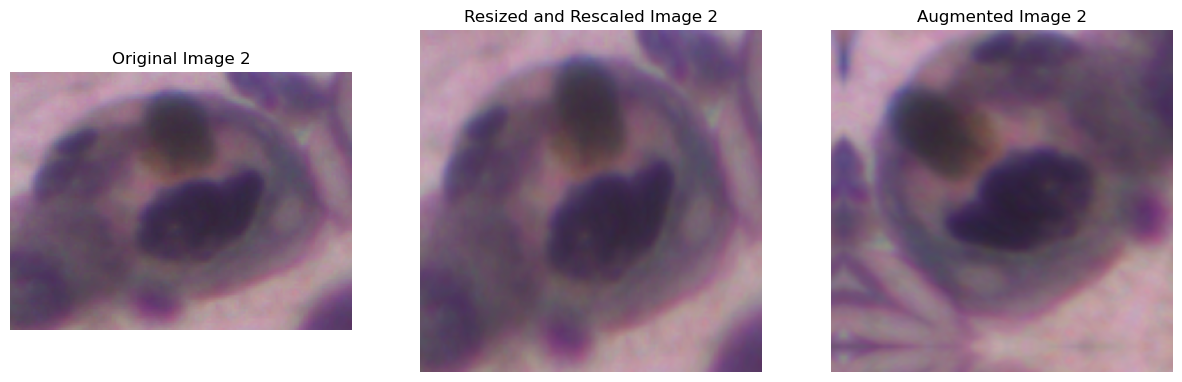

Original image shape: (1, 164, 122, 3)
Resized and rescaled image shape: (1, 256, 256, 3)


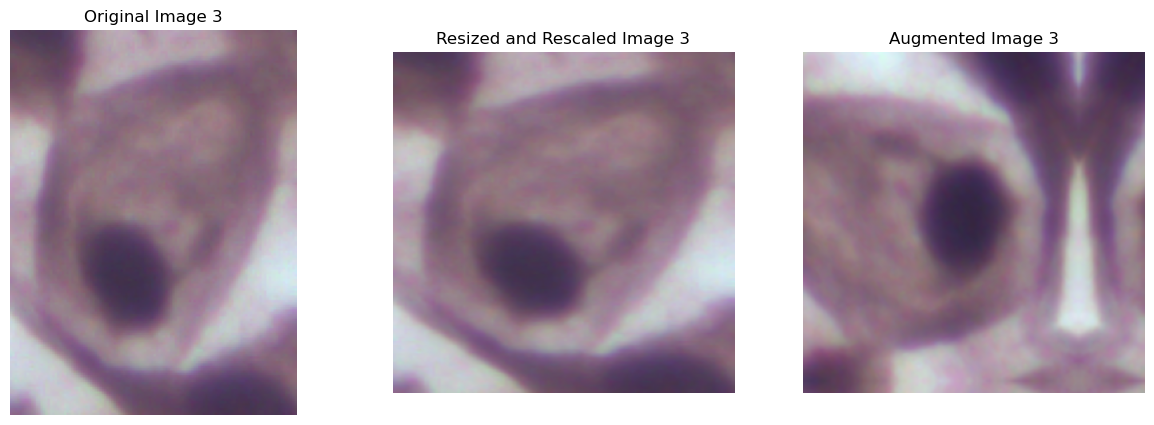

Original image shape: (1, 179, 185, 3)
Resized and rescaled image shape: (1, 256, 256, 3)


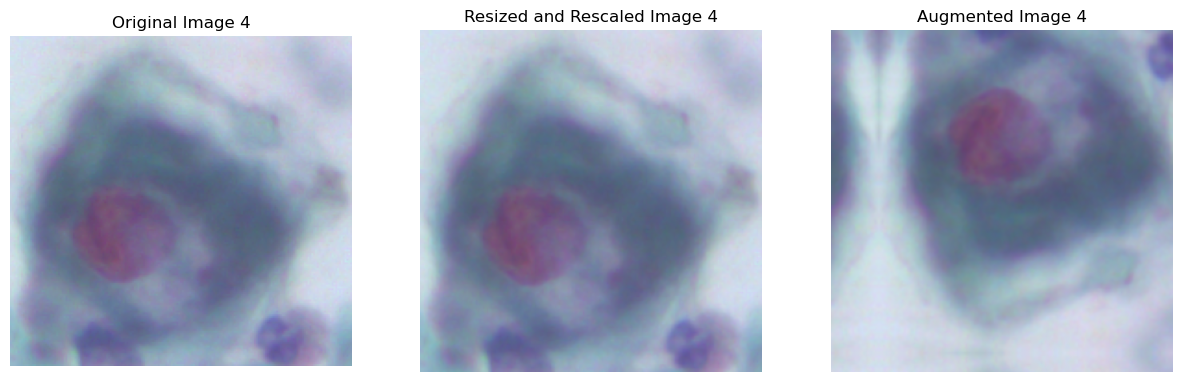

Original image shape: (1, 126, 131, 3)
Resized and rescaled image shape: (1, 256, 256, 3)


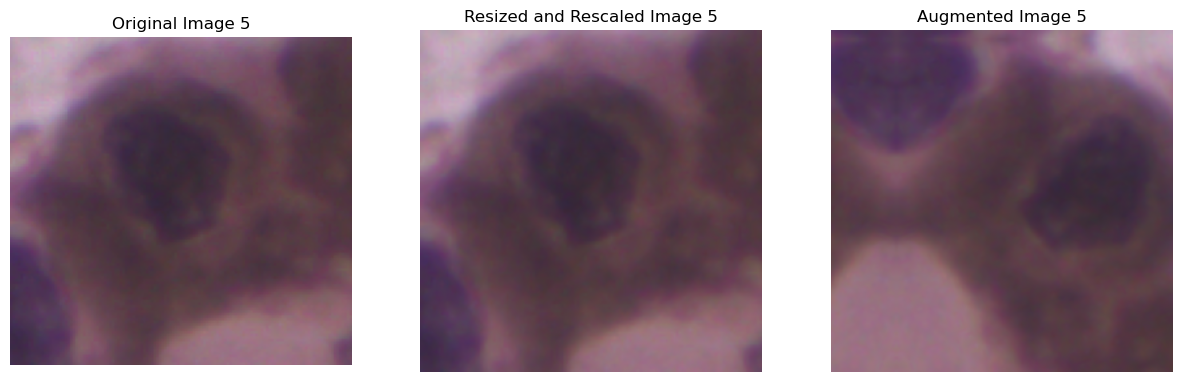

In [16]:
image_directory = "../cropped_images/Koilocytotic"
num_images_to_select = 5
display_random_images(image_directory, num_images_to_select)

# 4 - Model training

In [46]:
input_shape = (batch_size, img_width, img_height, 3)
n_classes = 5

In [47]:
# Building a CNN model
model = Sequential([

    resize_and_rescale,
    
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(rate=0.2),
    Dense(256, activation='relu'),
    Dropout(rate=0.2),
    Dense(5, activation='softmax')
])

model.build(input_shape=(None,None,None,3))

In [48]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 63, 63, 128)      

In [49]:
# Compile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt_adam = Adam(learning_rate=0.001)

model.compile(optimizer=opt_adam, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint callback - save best weights
chekpoint = ModelCheckpoint(filepath='../models/best_weights.hdf5', save_best_only=True, verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='min')

In [51]:
# Train the model
history = model.fit(train_ds,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=val_ds,
                    callbacks=[early_stop, chekpoint],
                    verbose=1)

Epoch 1/200
51/51 [==============================] - ETA: 0s - loss: 1.2798 - accuracy: 0.4235
Epoch 1: val_loss improved from inf to 1.22673, saving model to ../models\best_weights.hdf5
51/51 [==============================] - 20s 364ms/step - loss: 1.2798 - accuracy: 0.4235 - val_loss: 1.2267 - val_accuracy: 0.4329
Epoch 2/200
51/51 [==============================] - ETA: 0s - loss: 1.0950 - accuracy: 0.5586
Epoch 2: val_loss improved from 1.22673 to 0.96544, saving model to ../models\best_weights.hdf5
51/51 [==============================] - 17s 324ms/step - loss: 1.0950 - accuracy: 0.5586 - val_loss: 0.9654 - val_accuracy: 0.6329
Epoch 3/200
51/51 [==============================] - ETA: 0s - loss: 0.9064 - accuracy: 0.6571
Epoch 3: val_loss improved from 0.96544 to 0.94012, saving model to ../models\best_weights.hdf5
51/51 [==============================] - 16s 320ms/step - loss: 0.9064 - accuracy: 0.6571 - val_loss: 0.9401 - val_accuracy: 0.6282
Epoch 4/200
51/51 [================

# 5 - Model testing and Predictions

In [52]:
# Evaluate the model
model.load_weights('../models/best_weights.hdf5')
loss, accuracy = model.evaluate(test_ds)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

6/6 [==============================] - 2s 332ms/step - loss: 0.2284 - accuracy: 0.9141
Test Loss: 0.22838713228702545
Test Accuracy: 0.9140625


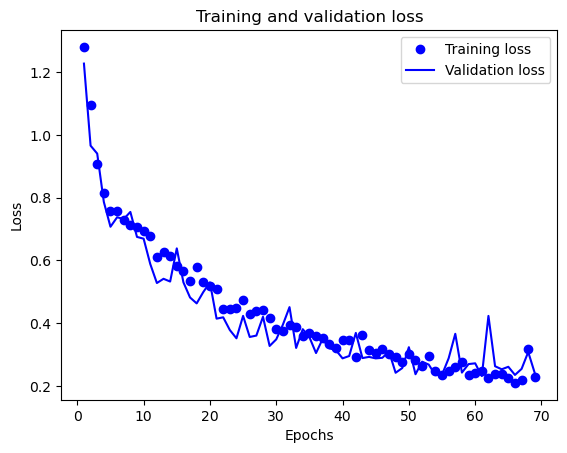

In [53]:
# Loss visualiztion
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
from keras.utils import img_to_array, load_img

def predictions(model, img):
    img_array = img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


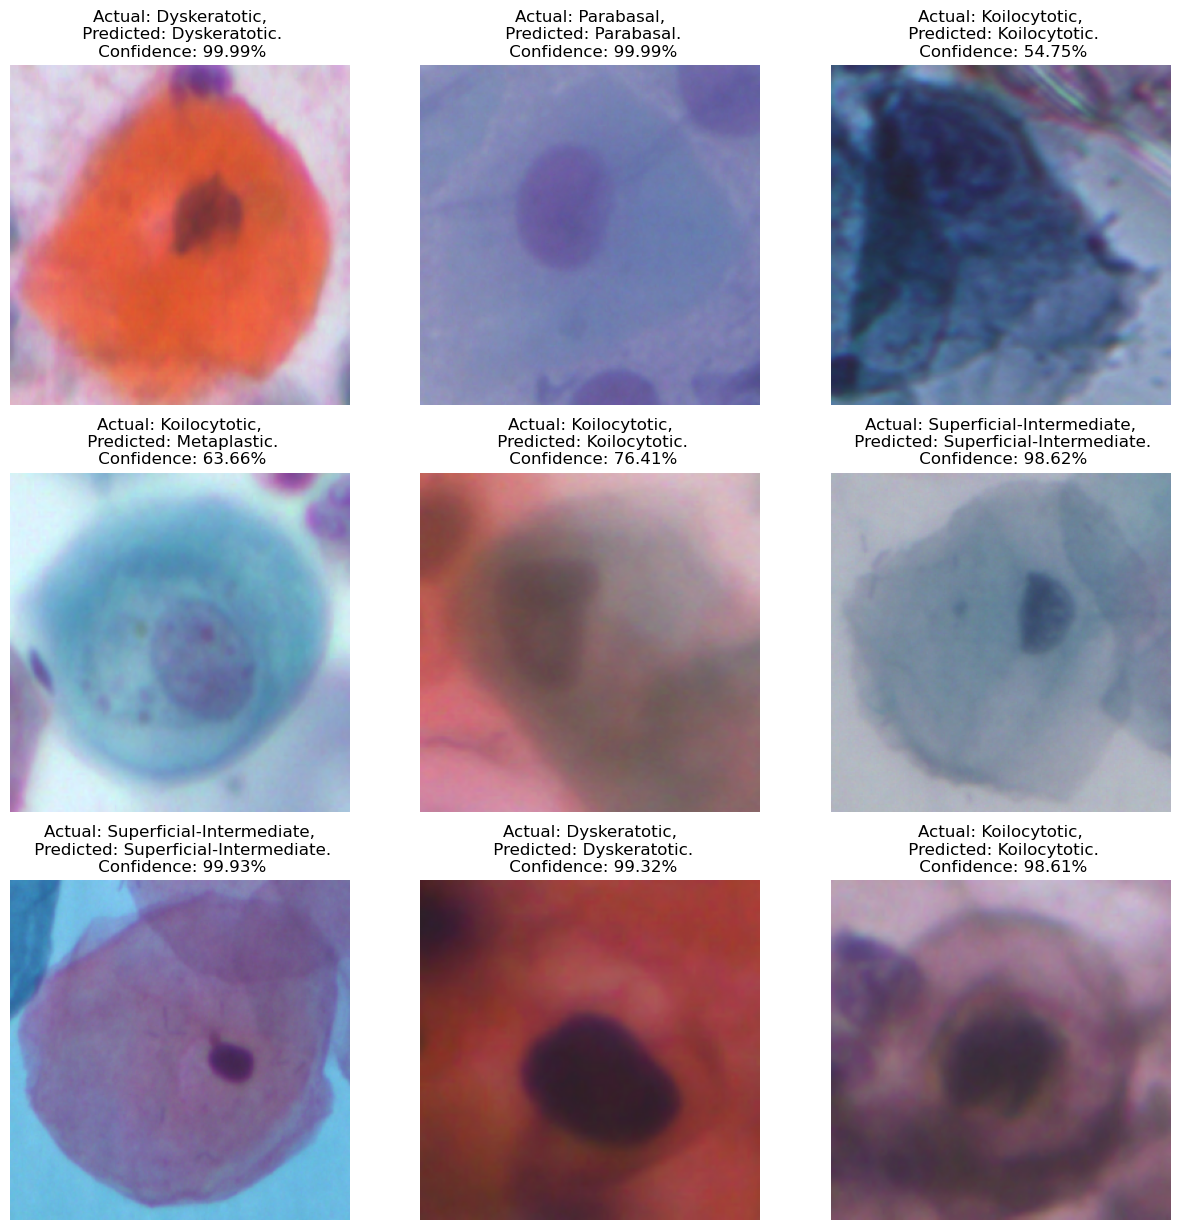

In [55]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predictions(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# 6 - Save the model

In [56]:
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

In [57]:
# Or just save it directly with chosen name
model.save("../models/cytology_8.h5")